# Main Results

Here we supply most of the results created during this project. The results are generated by loading the final model selected by early stopping for each of the experiments. Results might vary slightly due to randomness 

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.nn.functional as F  # All functions that don't have any parameters
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, matthews_corrcoef
import seaborn as sns



In [2]:
X_train = np.load('data/X_train_pca.npz')['arr_0']
X_val = np.load('data/X_val_pca.npz')['arr_0']
X_test = np.load('data/X_test_pca.npz')['arr_0']

y_train = np.load('data/y_train.npz')['arr_0']
y_val = np.load('data/y_val.npz')['arr_0']
y_test = np.load('data/y_test.npz')['arr_0']

nsamples, nx, ny = X_val.shape
print("val set shape:", nsamples, nx, ny)

p_pos = len(y_val[y_val == 1]) / len(y_val) * 100
print("Percent positive samples in val:", p_pos)


val_ds = []
for i in range(len(X_val)):
    val_ds.append([np.transpose(X_val[i]), y_val[i]])

test_ds = []
for i in range(len(X_test)):
    test_ds.append([np.transpose(X_test[i]), y_test[i]])

bat_size = 64
print("\nNOTE:\nSetting batch-size to", bat_size)
val_ldr = torch.utils.data.DataLoader(val_ds, batch_size=bat_size, shuffle=True)
test_ldr = torch.utils.data.DataLoader(test_ds, batch_size=bat_size, shuffle=True)



val set shape: 1526 241 154
Percent positive samples in val: 24.901703800786372

NOTE:
Setting batch-size to 64


## Define functions for evaluation of models

In [3]:
def plot_roc(targets, predictions):
    # ROC
    fpr, tpr, threshold = metrics.roc_curve(targets, predictions)
    roc_auc = metrics.auc(fpr, tpr)

    # plot ROC
    plt.figure()
    plt.title("Receiver Operating Characteristic")
    plt.plot(fpr, tpr, "b", label="AUC = %0.2f" % roc_auc)
    plt.legend(loc="lower right")
    plt.plot([0, 1], [0, 1], "r--")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    # plt.show()

def evaluate_model(model):
    model.eval()

    # Evaluate validation for selecting MCC
    val_preds, val_preds_auc, val_targs = [], [], []
    with torch.no_grad():

        
        for data, target in val_ldr:  
            x_batch_val = data.float().detach()
            y_batch_val = target.float().detach().unsqueeze(1)

            output = model(x_batch_val)

            # preds = np.round(output.cpu().detach())
            preds = output.cpu().detach()
            val_preds += list(preds.cpu().data.numpy().flatten())
            preds_auc = output.cpu().detach()
            val_preds_auc += list(preds_auc.data.numpy().flatten())
            val_targs += list(np.array(y_batch_val.cpu()))

    # Evaluate Test
    test_preds, test_preds_auc, test_targs, seqs = [], [], [], []
    with torch.no_grad():
        for data, target in test_ldr: 
            x_batch_val = data.float().detach()
            y_batch_val = target.float().detach().unsqueeze(1)
            seqs.append(x_batch_val[:,:20,:])
            output = model(x_batch_val)

            preds = np.round(output.cpu().detach())
            test_preds += list(preds.cpu().data.numpy().flatten())
            preds_auc = output.cpu().detach()
            test_preds_auc += list(preds_auc.data.numpy().flatten())
            test_targs += list(np.array(y_batch_val.cpu()))

    # Selection of the best MCC
    best_mcc = 0
    best_threshold = None
    thresholds = np.linspace(0.01,0.99,50)
    for threshold in thresholds:
        rounded_preds = (val_preds > threshold).astype(int)
        mcc = matthews_corrcoef(val_targs, rounded_preds)
        if mcc > best_mcc:
            best_mcc = mcc
            best_threshold = threshold
            
    
    print("After training, the best MCC found is {} with threshold = {}".format(best_mcc,best_threshold))
    val_preds = (val_preds > best_threshold).astype(int)
    test_preds = (test_preds > best_threshold).astype(int)


    print("MCC Validation:", matthews_corrcoef(val_targs, val_preds))
    prec_val = metrics.precision_score(val_targs, val_preds)
    rec_val = metrics.recall_score(val_targs, val_preds)
    f1_val = 2 * ((prec_val * rec_val) / (prec_val + rec_val))

    print("Precision Validation:", prec_val)
    print("Recall Validation:", rec_val)
    print("F1 Validation:", f1_val)


    print("Confusion matrix Validation:", confusion_matrix(val_targs, val_preds), sep="\n")

    print('Last partition')
    print("MCC Test:", matthews_corrcoef(test_targs, test_preds))
    print("MCC Test optimal MCC:", matthews_corrcoef(test_targs, test_preds))

    prec_test = metrics.precision_score(test_targs, test_preds)
    rec_test = metrics.recall_score(test_targs, test_preds)
    f1_test = 2 * ((prec_test * rec_test) / (prec_test + rec_test))

    print("Precision Test:", prec_test)
    print("Recall Test:", rec_test)
    print("F1 Test:", f1_test)

    print("Confusion matrix test:", confusion_matrix(test_targs, test_preds), sep="\n")

    plot_roc(test_targs, test_preds_auc)


    return test_targs, test_preds, test_preds_auc, seqs

## Vanilla architecture

#### Loading the data used to evaluate the model

In [4]:
data_list = []
target_list = []

import glob

for fp in glob.glob("hackathon_data_scripts/data/train/*input.npz"):
    data = np.load(fp)["arr_0"]
    targets = np.load(fp.replace("input", "labels"))["arr_0"]

    data_list.append(data)
    target_list.append(targets)
# print(data_list)

# Note:
# Choose your own training and val set based on data_list and target_list
# Here using the last partition as val set

X_train = np.concatenate(data_list[:-1])
y_train = np.concatenate(target_list[:-1])
nsamples, nx, ny = X_train.shape
print("Training set shape:", nsamples, nx, ny)

X_val = np.concatenate(data_list[-1:])
y_val = np.concatenate(target_list[-1:])
nsamples, nx, ny = X_val.shape
print("val set shape:", nsamples, nx, ny)

X_test = np.load('hackathon_data_scripts/data/final_test/P5_input.npz')["arr_0"]
y_test = np.load('hackathon_data_scripts/data/final_test/P5_labels.npz')["arr_0"]
print("Test set shape:", nsamples, nx, ny)

p_neg = len(y_train[y_train == [1]]) / len(y_train) * 100
print("Percent positive samples in train:", p_neg)

p_pos = len(y_val[y_val == 1]) / len(y_val) * 100
print("Percent positive samples in val:", p_pos)

# make the data set into one dataset that can go into dataloader
train_ds = []
for i in range(len(X_train)):
    train_ds.append([np.transpose(X_train[i]), y_train[i]])

val_ds = []
for i in range(len(X_val)):
    val_ds.append([np.transpose(X_val[i]), y_val[i]])

test_ds = []
for i in range(len(X_test)):
    test_ds.append([np.transpose(X_test[i]), y_test[i]])


bat_size = 64
print("\nNOTE:\nSetting batch-size to", bat_size)
train_ldr = torch.utils.data.DataLoader(train_ds, batch_size=bat_size, shuffle=True)
val_ldr = torch.utils.data.DataLoader(val_ds, batch_size=bat_size, shuffle=True)
test_ldr = torch.utils.data.DataLoader(test_ds, batch_size=bat_size, shuffle=True)

Training set shape: 4174 420 54
val set shape: 1532 420 54
Test set shape: 1532 420 54
Percent positive samples in train: 24.96406324868232
Percent positive samples in val: 25.0

NOTE:
Setting batch-size to 64


In [5]:
_, input_size, n_features = X_train.shape
num_classes = 1
# learning_rate = 0.01
learning_rate = 0.001

loss_weight = sum(y_train) / len(y_train)
print("loss weight", loss_weight)

class Net(nn.Module):
    def __init__(self,  num_classes):
        super(Net, self).__init__()   
        self.bn0 = nn.BatchNorm1d(n_features)
        self.conv1 = nn.Conv1d(in_channels=n_features, out_channels=100, kernel_size=3, stride=2, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv1.weight)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv1_bn = nn.BatchNorm1d(100)
        
        self.conv2 = nn.Conv1d(in_channels=100, out_channels=100, kernel_size=3, stride=2, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv2.weight)
        self.conv2_bn = nn.BatchNorm1d(100)
        
#         self.fc1 = nn.Linear(2600, num_classes)
#         torch.nn.init.xavier_uniform_(self.fc1.weight)
        

        self.rnn = nn.LSTM(input_size=100,hidden_size=26,num_layers=3, dropout=0.1, batch_first=True, bidirectional = True)
        self.drop = nn.Dropout(p = 0.1)
        self.fc1 = nn.Linear(26*2, num_classes)
        torch.nn.init.xavier_uniform_(self.fc1.weight)

        

    def forward(self, x):

        x = self.bn0(x)  
        x = self.pool(F.relu(self.conv1(x)))
        x = self.conv1_bn(x)
        x = self.drop(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.conv2_bn(x)
        x = self.drop(x)
        x = x.transpose_(2, 1)
        x, (h, c) = self.rnn(x)
        cat = torch.cat((h[-2, :, :], h[-1, :, :]), dim=1)
        cat = self.drop(cat)
        x = torch.sigmoid(self.fc1(cat))

        
        return x
    
# Initialize network
net = Net(num_classes=num_classes)

# Loss and optimizer
# criterion = nn.BCELoss()
criterion = nn.BCELoss(reduction='none')  # for weighted loss
# optimizer = optim.SGD(net.parameters(), lr=learning_rate)
optimizer = optim.Adam(net.parameters(), lr=learning_rate,
    weight_decay=0.0005,
    amsgrad=True
)

loss weight 0.2496406324868232


In [6]:
vanilla_model = torch.load('001.vanilla_model/early_stopping_model.pt')
print(vanilla_model)

Net(
  (bn0): BatchNorm1d(54, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv1d(54, 100, kernel_size=(3,), stride=(2,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1_bn): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(2,), padding=(1,))
  (conv2_bn): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rnn): LSTM(100, 26, num_layers=3, batch_first=True, dropout=0.1, bidirectional=True)
  (drop): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=52, out_features=1, bias=True)
)


After training, the best MCC found is 0.568013700539511 with threshold = 0.67
MCC Validation: 0.568013700539511
Precision Validation: 0.7568493150684932
Recall Validation: 0.577023498694517
F1 Validation: 0.6548148148148147
Confusion matrix Validation:
[[1078   71]
 [ 162  221]]
Last partition
MCC Test: 0.4130044978276334
MCC Test optimal MCC: 0.4130044978276334
Precision Test: 0.546875
Recall Test: 0.5813953488372093
F1 Test: 0.5636070853462157
Confusion matrix test:
[[761 145]
 [126 175]]


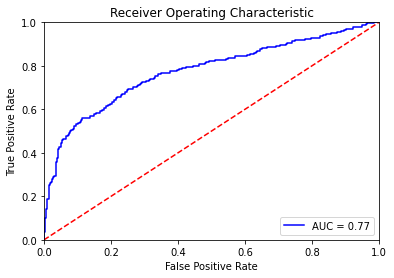

In [7]:
target, pred, scores, seqs = evaluate_model(vanilla_model)

## Improved archiecture

In [8]:
# Hyperparameters
# input_size = 420
_, input_size, n_features = X_train.shape
n_local_feat = 27
n_global_feat = n_features - n_local_feat
num_classes = 1
# learning_rate = 0.01
learning_rate = 0.001

loss_weight = sum(y_train) / len(y_train)
print("loss weight", loss_weight)

class Net(nn.Module):
    def __init__(self,  num_classes):
        super(Net, self).__init__()   
        self.bn0 = nn.BatchNorm1d(n_local_feat)
        self.conv1 = nn.Conv1d(in_channels=n_local_feat, out_channels=100, kernel_size=3, stride=2, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv1.weight)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv1_bn = nn.BatchNorm1d(100)
        
        self.conv2 = nn.Conv1d(in_channels=100, out_channels=100, kernel_size=3, stride=2, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv2.weight)
        self.conv2_bn = nn.BatchNorm1d(100)
        
        ######## code from master thesis 
        self.rnn = nn.LSTM(input_size=100,hidden_size=26,num_layers=3, dropout=0.5, batch_first=True, bidirectional = True)
        self.drop = nn.Dropout(p = 0.5) # Dunno if dropout should be even higher?? - Christian
        self.fc1 = nn.Linear(26*2 + n_global_feat, 26*2 + n_global_feat)
        torch.nn.init.kaiming_uniform_(self.fc1.weight)
        ########
        
        # since we add new features in this step, we have to use batch normalization again
        self.bn1 = nn.BatchNorm1d(26*2 + n_global_feat)
        # if we pipe the global terms innto the fc, we should have more than just 1
        self.fc2 = nn.Linear(26*2 + n_global_feat, 26*2 + n_global_feat)
        torch.nn.init.kaiming_uniform_(self.fc2.weight)

        self.fc3 = nn.Linear(26*2 + n_global_feat, num_classes)
        torch.nn.init.kaiming_uniform_(self.fc2.weight)
    def forward(self, x):
        local_features = x[:, :27, :]
        # global features are the same for the whole sequence -> take first value
        global_features = x[:, 27:, 0]
        
        ######## code from master thesis
        x = self.bn0(local_features)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.conv1_bn(x)
        x = self.drop(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.conv2_bn(x)
        x = self.drop(x)
        x = x.transpose_(2, 1)
        x, (h, c) = self.rnn(x)
        # concatenate bidirectional output of last layer
        cat = torch.cat((h[-2, :, :], h[-1, :, :]), dim=1)
        # add global features
        x = torch.cat((cat, global_features), dim=1)
        x = self.drop(x)
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = torch.sigmoid(self.fc3(x))
        ########
        
        return x
    
# Initialize network
net = Net(num_classes=num_classes)
# Loss and optimizer
criterion = nn.BCELoss(reduction='none')  # for weighted loss
# optimizer = optim.SGD(net.parameters(), lr=learning_rate)
optimizer = optim.Adam(net.parameters(), lr=learning_rate,
    weight_decay=0.0005,
    amsgrad=True
)

loss weight 0.2496406324868232


In [9]:
print(net)
print(X_train.shape)

Net(
  (bn0): BatchNorm1d(27, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv1d(27, 100, kernel_size=(3,), stride=(2,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1_bn): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(2,), padding=(1,))
  (conv2_bn): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rnn): LSTM(100, 26, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=79, out_features=79, bias=True)
  (bn1): BatchNorm1d(79, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=79, out_features=79, bias=True)
  (fc3): Linear(in_features=79, out_features=1, bias=True)
)
(4174, 420, 54)


After training, the best MCC found is 0.6302514170344617 with threshold = 0.63
MCC Validation: 0.6302514170344617
Precision Validation: 0.868
Recall Validation: 0.566579634464752
F1 Validation: 0.6856240126382307
Confusion matrix Validation:
[[1116   33]
 [ 166  217]]
Last partition
MCC Test: 0.5502010428725541
MCC Test optimal MCC: 0.5502010428725541
Precision Test: 0.6448598130841121
Recall Test: 0.6877076411960132
F1 Test: 0.6655948553054662
Confusion matrix test:
[[792 114]
 [ 94 207]]


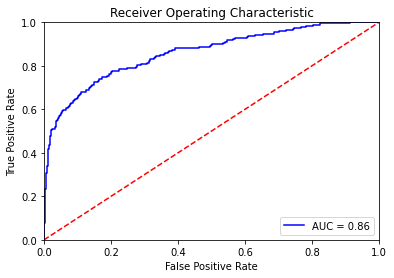

In [10]:
improved_model = torch.load('002.architecture/early_stopping_model.pt')
target, pred, scores, seqs  = evaluate_model(improved_model)

## BLOSUM model

In [11]:
# Functions to do BLOSUM encoding
def blosumEncode(sequence):
    blosum = {'A': [1.0,-0.2,-0.4,-0.2,-0.6,0.0,-0.4,-0.2,-0.2,-0.4,-0.2,-0.2,-0.2,-0.2,-0.4,0.2,0.0,0.0,-0.6,-0.4],
 'C': [-0.2,2.6,-0.8,-0.6,-0.4,-0.6,-0.6,-0.4,-0.6,-0.4,-0.4,-0.4,-0.8,-0.6,-0.8,-0.2,-0.2,-0.2,-1.0,-0.6],
 'D': [-0.4,-0.8,1.6,0.4,-1.0,-0.2,-0.2,-0.8,-0.2,-0.8,-0.8,0.4,-0.2,0.0,-0.4,0.0,-0.2,-0.8,-1.0,-0.6],
 'E': [-0.2,-0.6, 0.4,1.2,-0.6,-0.6,0.0,-0.8,0.2,-0.6,-0.4,0.0,-0.2,0.4,0.0,-0.2,-0.2,-0.6,-0.6,-0.4],
 'F': [-0.6,-0.4,-1.0,-0.6,1.6,-0.8,-0.2,0.0,-0.8,0.2,0.0,-0.8,-0.8,-0.8,-0.6,-0.6,-0.4,-0.2,0.2,0.8],
 'G': [0.0,-0.6,-0.2,-0.6,-0.8,1.6,-0.4,-0.8,-0.4,-0.8,-0.6,0.0,-0.4,-0.4,-0.6,0.0,-0.4,-0.8,-0.6,-0.6],
 'H': [-0.4,-0.6,-0.2,0.0,-0.2,-0.4,2.0,-0.8,0.0,-0.6,-0.2,0.2,-0.4,0.2,0.0,-0.2,-0.4,-0.8,-0.6,0.4],
 'I': [-0.2,-0.4,-0.8,-0.8,0.0,-0.8,-0.8,1.0, -0.6,0.4,0.4,-0.6,-0.6,-0.6,-0.8,-0.6,-0.2,0.8,-0.6,-0.2],
 'K': [-0.2,-0.6,-0.2,0.2,-0.8,-0.4,0.0,-0.6,1.2,-0.6,-0.4,0.0,-0.2,0.4,0.6,0.0,-0.2,-0.6,-0.6,-0.4],
 'L': [-0.4,-0.4,-0.8,-0.6,0.2,-0.8,-0.6,0.4,-0.6,1.0,0.6,-0.8,-0.8,-0.4,-0.6,-0.6,-0.2,0.2,-0.4,-0.2],
 'M': [-0.2,-0.4,-0.8,-0.4,0.0,-0.6,-0.2,0.4,-0.4,0.6,1.4,-0.4,-0.6,0.0,-0.4,-0.4,-0.2,0.2,-0.2,0.0],
 'N': [-0.2,-0.4,0.4,0.0,-0.8,0.0,0.2,-0.6,0.0,-0.8,-0.4,1.4,-0.4,0.0,-0.2,0.2,0.0,-0.6,-0.8,-0.4],
 'P': [-0.2,-0.8,-0.2,-0.2,-0.8,-0.4,-0.4,-0.6,-0.2,-0.8,-0.6,-0.4,2.0,-0.2,-0.6,-0.2,-0.2,-0.6,-0.8,-0.6],
 'Q': [-0.2,-0.6,0.0,0.4,-0.8,-0.4,0.2,-0.6,0.4,-0.4,0.0,0.0,-0.2,1.4,0.2,0.0,-0.2,-0.6,-0.2,-0.2],
 'R': [-0.4,-0.8,-0.4,0.0,-0.6,-0.6,0.0,-0.8,0.6,-0.6,-0.4,-0.2,-0.6,0.2,1.4,-0.2,-0.2,-0.6,-0.6,-0.2],
 'S': [0.2,-0.2,0.0,-0.2,-0.6,0.0,-0.2,-0.6,0.0,-0.6,-0.4,0.2,-0.2,0.0,-0.2,1.0,0.4,-0.4,-0.8,-0.4],
 'T': [0.0,-0.2,-0.2,-0.2,-0.4,-0.4,-0.4,-0.2,-0.2,-0.2,-0.2,0.0,-0.2,-0.2,-0.2,0.4,1.0,0.0,-0.6,-0.4],
 'V': [0.0,-0.2,-0.8,-0.6,-0.2,-0.8,-0.8,0.8,-0.6,0.2,0.2,-0.6,-0.6,-0.6,-0.6,-0.4,0.0,1.0,-0.6,-0.2],
 'W': [-0.6,-1.0,-1.0,-0.6,0.2,-0.6,-0.6,-0.6,-0.6,-0.4,-0.2,-0.8,-0.8,-0.2,-0.6,-0.8,-0.6,-0.6,3.0,0.4],
 'Y': [-0.4,-0.6,-0.6,-0.4,0.8,-0.6,0.4,-0.2,-0.4,-0.2,0.0,-0.4,-0.6,-0.2,-0.2,-0.4,-0.4,-0.2,0.4,1.6]}
    encoding = []
    for residue in sequence:
        encoding.append(blosum[residue])
    while len(encoding) < 420:
        encoding.append([0]*20)
    return np.array(encoding)
    
def reverseOneHot(encoding):
    """
    Converts one-hot encoded array back to string sequence
    """
    mapping = dict(zip(range(20), "ACDEFGHIKLMNPQRSTVWY"))
    seq = ""
    for i in range(len(encoding)):
        if np.max(encoding[i]) > 0:
            seq += mapping[np.argmax(encoding[i])]
    return seq
    
def to_blossum(X_data):
    for i, arr in enumerate(X_data):
        seq=reverseOneHot(arr[:,0:20])
        arr = blosumEncode(seq)
        X_data[i][:,0:20] = arr
    return X_data

In [12]:
# Convert data set to BLOSUM version
X_train = to_blossum(X_train)
X_val = to_blossum(X_val)
X_test = to_blossum(X_test)

train_ds = []
for i in range(len(X_train)):
    train_ds.append([np.transpose(X_train[i]), y_train[i]])

val_ds = []
for i in range(len(X_val)):
    val_ds.append([np.transpose(X_val[i]), y_val[i]])

test_ds = []
for i in range(len(X_test)):
    test_ds.append([np.transpose(X_test[i]), y_test[i]])


bat_size = 64
print("\nNOTE:\nSetting batch-size to", bat_size)
train_ldr = torch.utils.data.DataLoader(train_ds, batch_size=bat_size, shuffle=True)
val_ldr = torch.utils.data.DataLoader(val_ds, batch_size=bat_size, shuffle=True)
test_ldr = torch.utils.data.DataLoader(test_ds, batch_size=bat_size, shuffle=False)

_, input_size, n_features = X_train.shape
n_local_feat = 27
n_global_feat = n_features - n_local_feat
num_classes = 1
# learning_rate = 0.01
learning_rate = 0.001

loss_weight = sum(y_train) / len(y_train)
print("loss weight", loss_weight)

class Net(nn.Module):
    def __init__(self,  num_classes):
        super(Net, self).__init__()   
        self.bn0 = nn.BatchNorm1d(n_local_feat)
        self.conv1 = nn.Conv1d(in_channels=n_local_feat, out_channels=100, kernel_size=3, stride=2, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv1.weight)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv1_bn = nn.BatchNorm1d(100)
        
        self.conv2 = nn.Conv1d(in_channels=100, out_channels=100, kernel_size=3, stride=2, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv2.weight)
        self.conv2_bn = nn.BatchNorm1d(100)
        
        ######## code from master thesis
        self.rnn = nn.LSTM(input_size=100,hidden_size=26,num_layers=3, dropout=0.5, batch_first=True, bidirectional = True)
        self.drop = nn.Dropout(p = 0.5)
        # size is due to 26 hidden neurons from * 2 directions
        self.fc1 = nn.Linear(26*2 + n_global_feat, 26*2 + n_global_feat)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        ########
        
        # since we add new features in this step, we have to use batch normalization again
        self.bn1 = nn.BatchNorm1d(26*2 + n_global_feat)
        # if we pipe the global terms innto the fc, we should have more than just 1
        self.fc2 = nn.Linear(26*2 + n_global_feat, 26*2 + n_global_feat)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        self.fc3 = nn.Linear(26*2 + n_global_feat, num_classes)
        torch.nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x):
        local_features = x[:, :27, :]
        # global features are the same for the whole sequence -> take first value
        global_features = x[:, 27:, 0]

        ######## code from master thesis
        x = self.bn0(local_features)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.conv1_bn(x)
        x = self.drop(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.conv2_bn(x)
        x = self.drop(x)
        x = x.transpose_(2, 1)
        x, (h, c) = self.rnn(x)
        # concatenate bidirectional output of last layer
        cat = torch.cat((h[-2, :, :], h[-1, :, :]),dim=1)

        # add global features
        x = torch.cat((cat, global_features), dim=1)
        x = self.drop(x)
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = torch.sigmoid(self.fc3(x))
        ########
        
        return x
    
# Initialize network
net = Net(num_classes=num_classes)

# Loss and optimizer
criterion = nn.BCELoss(reduction='none')  # for weighted loss
# optimizer = optim.SGD(net.parameters(), lr=learning_rate)
optimizer = optim.Adam(net.parameters(), lr=learning_rate,
    weight_decay=0.0005,
    amsgrad=True
)


NOTE:
Setting batch-size to 64
loss weight 0.2496406324868232


After training, the best MCC found is 0.6679759214268836 with threshold = 0.65
MCC Validation: 0.6679759214268836
Precision Validation: 0.8435374149659864
Recall Validation: 0.6475195822454308
F1 Validation: 0.7326440177252584
Confusion matrix Validation:
[[1103   46]
 [ 135  248]]
Last partition
MCC Test: 0.5739145527873301
MCC Test optimal MCC: 0.5739145527873301
Precision Test: 0.6516516516516516
Recall Test: 0.7209302325581395
F1 Test: 0.6845425867507887
Confusion matrix test:
[[790 116]
 [ 84 217]]


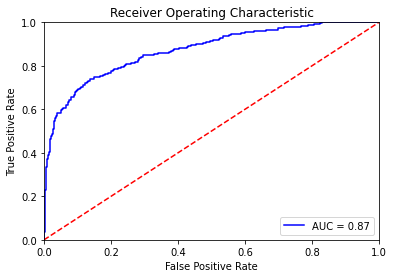

In [13]:
blosum = torch.load('004.blossum/early_stopping_model.pt')
target, pred, scores, seqs = evaluate_model(blosum)

## ESM transformed embeddings

In [14]:
X_train = np.load('data/X_train_pca.npz')['arr_0']
X_val = np.load('data/X_val_pca.npz')['arr_0']
X_test = np.load('data/X_test_pca.npz')['arr_0']

y_train = np.load('data/y_train.npz')['arr_0']
y_val = np.load('data/y_val.npz')['arr_0']
y_test = np.load('data/y_test.npz')['arr_0']


train_ds = []
for i in range(len(X_train)):
    train_ds.append([np.transpose(X_train[i]), y_train[i]])

val_ds = []
for i in range(len(X_val)):
    val_ds.append([np.transpose(X_val[i]), y_val[i]])

test_ds = []
for i in range(len(X_test)):
    test_ds.append([np.transpose(X_test[i]), y_test[i]])


bat_size = 64
print("\nNOTE:\nSetting batch-size to", bat_size)
train_ldr = torch.utils.data.DataLoader(train_ds, batch_size=bat_size, shuffle=True)
val_ldr = torch.utils.data.DataLoader(val_ds, batch_size=bat_size, shuffle=True)
test_ldr = torch.utils.data.DataLoader(test_ds, batch_size=bat_size, shuffle=True)


NOTE:
Setting batch-size to 64


In [15]:
_, input_size, n_features = X_train.shape
n_local_feat = 100 ##
n_global_feat = 27 
num_classes = 1
# learning_rate = 0.01
learning_rate = 0.001
weight_decay = 0.0005

loss_weight = sum(y_train) / len(y_train)
print("loss weight", loss_weight)

class Net(nn.Module):
    def __init__(self,  num_classes):
        super(Net, self).__init__()   
        self.bn0 = nn.BatchNorm1d(n_local_feat)
        self.conv1 = nn.Conv1d(in_channels=n_local_feat, out_channels=200, kernel_size=3, stride=2, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv1.weight)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv1_bn = nn.BatchNorm1d(200)
        
        self.conv2 = nn.Conv1d(in_channels=200, out_channels=100, kernel_size=3, stride=2, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv2.weight)
        self.conv2_bn = nn.BatchNorm1d(100)
        
        
        self.rnn1 = nn.LSTM(input_size=100,hidden_size=26,num_layers=1, batch_first=True, bidirectional = True)
        self.rnn2 = nn.LSTM(input_size=26*2,hidden_size=26,num_layers=1, batch_first=True, bidirectional = True)
        self.bn1 = nn.BatchNorm1d(26*2 + n_global_feat)
        self.drop = nn.Dropout(p = 0.6)
        self.fc1 = nn.Linear(26*2 + n_global_feat, 26*2 + n_global_feat)
        torch.nn.init.kaiming_uniform_(self.fc1.weight)

        
        # since we add new features in this step, we have to use batch normalization again
        
        # if we pipe the global terms innto the fc, we should have more than just 1
        self.fc2 = nn.Linear(26*2 + n_global_feat, (26*2 + n_global_feat))
        torch.nn.init.kaiming_uniform_(self.fc2.weight)

        self.fc3 = nn.Linear(26*2 + n_global_feat, num_classes)
        torch.nn.init.kaiming_uniform_(self.fc3.weight)

    def forward(self, x):
        # local_features = x[:, 20:27, :] ##
        # global features are the same for the whole sequence -> take first value
        global_features = x[:, 27:54, 0]
        esm_features = x[:, 54:, :]
        #local_features = torch.cat((local_features, esm_features),dim=1 )
        local_features = esm_features ##
        

        x = self.bn0(local_features)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.conv1_bn(x)
        x = self.drop(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.conv2_bn(x)
        x = x.transpose_(2, 1)
        x, (h, c) = self.rnn1(x)
        x = self.drop(x)
        x, (h, c) = self.rnn2(x)
        x = self.drop(x)
        x, (h, c) = self.rnn2(x)
        # concatenate bidirectional output of last layer
        cat = torch.cat((h[-2, :, :], h[-1, :, :]), dim=1)
        # add global features
        x = torch.cat((cat, global_features), dim=1)
        x = self.drop(x)
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = torch.sigmoid(self.fc3(x))

        
        return x


loss weight 0.25


After training, the best MCC found is 0.6901794834504008 with threshold = 0.87
MCC Validation: 0.6901794834504008
Precision Validation: 0.9045801526717557
Recall Validation: 0.6236842105263158
F1 Validation: 0.7383177570093458
Confusion matrix Validation:
[[1121   25]
 [ 143  237]]
Last partition
MCC Test: 0.5910489755836138
MCC Test optimal MCC: 0.5910489755836138
Precision Test: 0.6920529801324503
Recall Test: 0.6943521594684385
F1 Test: 0.693200663349917
Confusion matrix test:
[[813  93]
 [ 92 209]]


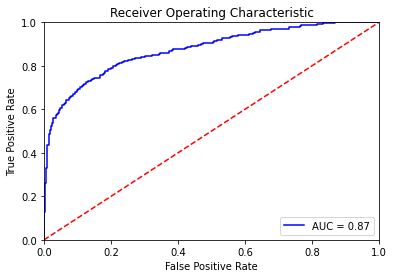

In [35]:
esm_model = torch.load('005.ESM_pca/early_stopping_model.pt')
esm_model.to('cpu')
target, pred, scores, seqs = evaluate_model(esm_model)

### Loss curve plot

The plot here was generated from the `esm_pca.py` in the `005.ESM_pca` folder.

<img src="plots/loss_curve.png" width=500 height=300 />

In [36]:
scores = np.array(scores)
target = np.array([x[0] for x in target])

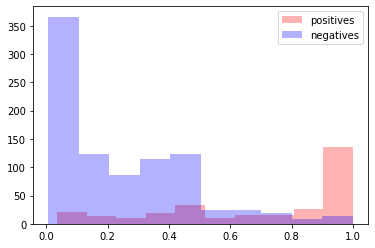

In [37]:
plt.hist(scores[target == 1], color='red', alpha=0.3, label='binding', bins=20)
plt.hist(scores[target == 0], color='blue', alpha=0.3, label='non-binding', bins=20)
plt.axvline(0.5, ls='--')
plt.axvline(0.87, ls=':', label="optimal MCC threshold")
plt.xlabel('Probability of binding')
plt.legend()
plt.tight_layout()
plt.savefig("plots/MCC_treshold.pdf")

In [38]:
merged_seqs = seqs[0]
for batch in seqs[1:]:
    merged_seqs = torch.cat((merged_seqs, batch), 0)
merged_seqs = merged_seqs.transpose(2,1)
merged_seqs = merged_seqs.numpy()

In [39]:
def extract_sequences(dataset_X):
    """
    Return DataFrame with MHC, peptide and TCR a/b sequences from
    one-hot encoded complex sequences in dataset X
    """
    pep_sequences = [reverseOneHot(arr[0:10, 0:20]) for arr in dataset_X]
    df_sequences = pd.DataFrame(
        {"peptide": pep_sequences}
    )
    return df_sequences

sequences = extract_sequences(merged_seqs)
sequences['predictions'] = pred
sequences['true'] = target
sequences['true'] = sequences['true'].explode()

In [60]:
sequences['correct_pred'] = sequences['predictions'] == sequences['true']
peptide_preds = sequences.groupby('peptide').agg({'peptide' : 'count',
                                  'correct_pred': sum})
peptide_preds['fraction_correct'] = peptide_preds['correct_pred'] / peptide_preds['peptide']
peptide_preds = peptide_preds.sort_values('fraction_correct', ascending=False)

In [ ]:
sequences_train = extract_sequences(X_train[:, :, :20])
peptide_preds_train = np.log2(sequences_train.groupby('peptide').agg({'peptide' : 'count'}))
peptide_preds_train.columns = ["occurence_train_set"]
peptide_preds = peptide_preds.join(peptide_preds_train)
peptide_preds = peptide_preds.fillna(0)

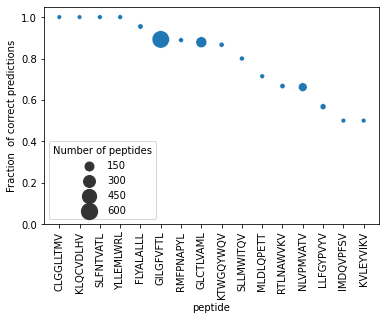

In [76]:
sns.scatterplot(data=peptide_preds, x=peptide_preds.index, y='fraction_correct', size='occurence_train_set', sizes=(20,300))
plt.xticks(rotation=90)
ax = plt.gca()
ax.set_ylim([0,1.05])
# ax.set_ylabel('Fraction of correct predictions')
ax.set_ylabel('Accuracy')
plt.legend(title='Number of examples\nin training set (log2)')
plt.tight_layout()
plt.savefig("plots/generalization_peptides.pdf")
plt.show()